#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

## Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Цель проекта

Создать модель для предсказания количества заказов такси на следующий час. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Задачи

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1">Описание данных</a></span></li><li><span><a href="#Цель-проекта" data-toc-modified-id="Цель-проекта-2">Цель проекта</a></span></li><li><span><a href="#Задачи" data-toc-modified-id="Задачи-3">Задачи</a></span></li><li><span><a href="#1.-Подготовка" data-toc-modified-id="1.-Подготовка-4">1. Подготовка</a></span></li><li><span><a href="#2.-Анализ" data-toc-modified-id="2.-Анализ-5">2. Анализ</a></span></li><li><span><a href="#3.-Обучение" data-toc-modified-id="3.-Обучение-6">3. Обучение</a></span></li><li><span><a href="#4.-Тестирование" data-toc-modified-id="4.-Тестирование-7">4. Тестирование</a></span></li><li><span><a href="#5.-Получение-прогноза-заказов-такси" data-toc-modified-id="5.-Получение-прогноза-заказов-такси-8">5. Получение прогноза заказов такси</a></span></li><li><span><a href="#6.-Выводы" data-toc-modified-id="6.-Выводы-9">6. Выводы</a></span></li></ul></div>

## 1. Подготовка

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from catboost import CatBoostRegressor

In [2]:
try:
    data = pd.read_csv('D:\\Хранилище информации\\DATA SCIENCE учеба\\projects\\taxi.csv', sep=',', encoding='utf-8')
    print('Прочитано с локального диска')
except:
    data = pd.read_csv('https://code.s3.yandex.net///datasets//taxi.csv', sep=',')
display(data.head())

Прочитано с локального диска


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


## 2. Анализ

Изменим тип данных для колонки с информацией о времени

In [4]:
data['datetime'] = pd.to_datetime(data['datetime'])

Установим эту колонку как индексную

In [5]:
data = data.set_index('datetime')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Отсортируем индекс таблицы

In [6]:
data.sort_index(inplace=True)
data.index.is_monotonic # проверим, в хронологическом ли порядке расположены даты и время

True

Проверим, какой промежуток времени представлен в данных.

In [7]:
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

Имеются данные с 1 марта по 31 августа 2018г.

Выполним ресемплирование по часу. Вызовем функцию sum() для агрегации значений, т.к. интересует суммарное количество такси за час.

In [8]:
data = data.resample('1H').sum()

In [9]:
len(data)

4416

Построем график заказов такси за полмесяца.

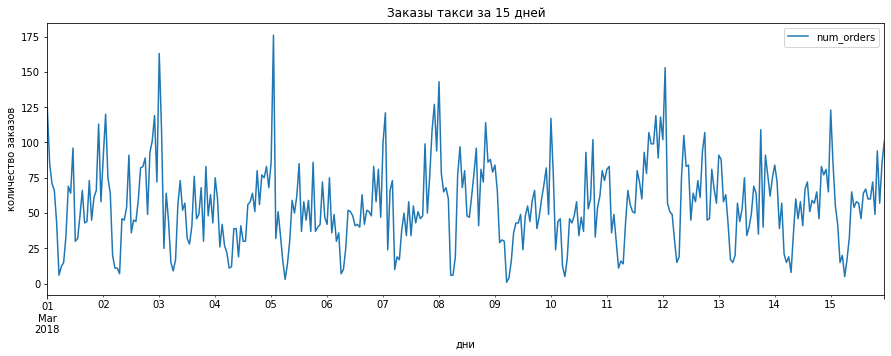

In [10]:
data['2018-03':'2018-03-15'].plot(title='Заказы такси за 15 дней', figsize=(15,5))
plt.xlabel('дни')
plt.ylabel('количество заказов')
plt.show()

Как видно, количество заказов не равномерно в течении суток.

Увеличим участок, построем график за трое суток.

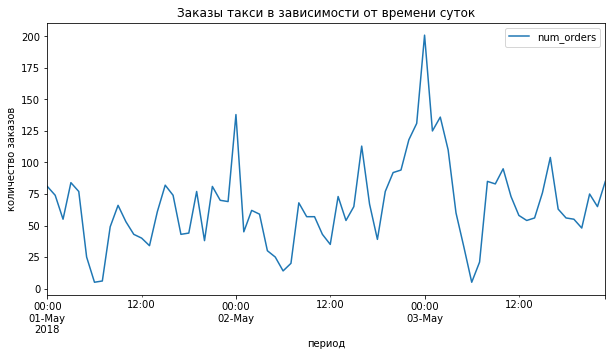

In [11]:
data['2018-05-01':'2018-05-03'].plot(title='Заказы такси в зависимости от времени суток', figsize=(10,5))
plt.xlabel('период')
plt.ylabel('количество заказов')
plt.show()

Пики заказов приходятся на ночные часы. Это время, когда другой транспорт не доступен.  
А минимум заказов наблюдаем утром: пассажиры полны сил и готовы добираться до места самостоятельно. Либо причина в расписании рейсов.

Проанализируем тренды и сезонность данных.

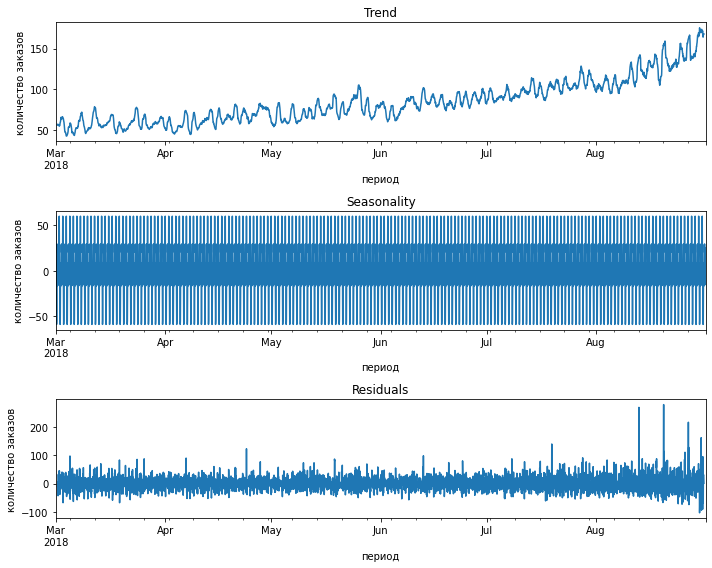

In [12]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(6, 8))

plt.subplot(311)

decomposed.trend.plot(ax=plt.gca(),figsize=(10,8)) # выделение тренда
plt.xlabel('период')
plt.ylabel('количество заказов')
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) # выделение сезонности
plt.xlabel('период')
plt.ylabel('количество заказов')
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())# выделение остаточного шума
plt.xlabel('период')
plt.ylabel('количество заказов')
plt.title('Residuals')

plt.tight_layout()

Восходящий тренд - от марта до августа количество заказов плавно растёт. 
Сезонность постром за более короткий промежуток.

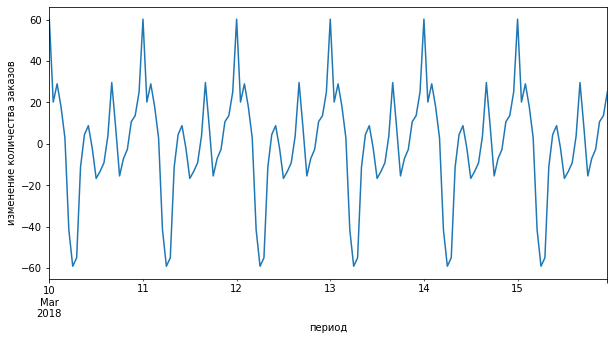

In [13]:
decomposed.seasonal['2018-03-10':'2018-03-15'].plot(ax=plt.gca(), figsize=(10,5))
plt.ylabel('изменение количества заказов')
plt.xlabel('период')
plt.show()

Наблюдается сезонность: пики - полночь, ямы - 6 утра.

In [14]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


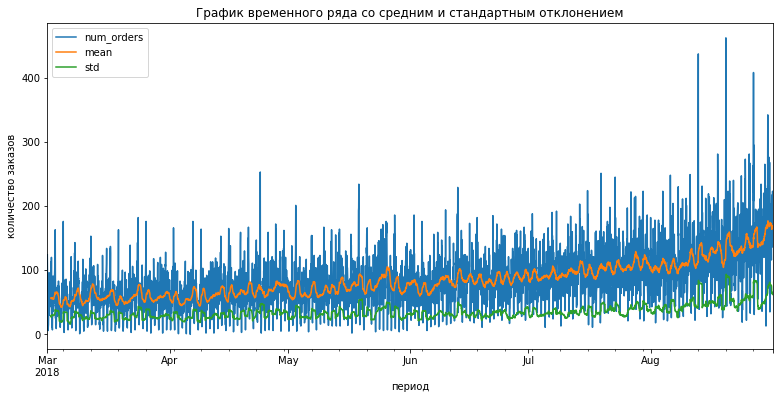

In [15]:
data['mean'] = data['num_orders'].rolling(24).mean()
data['std'] = data['num_orders'].rolling(24).std()
data.plot(figsize=(13,6), title=('График временного ряда со средним и стандартным отклонением'))
plt.xlabel('период')
plt.ylabel('количество заказов')
plt.show()

In [16]:
data.head(24)

,num_orders,mean,std
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN
2018-03-01 05:00:00,6,NaN,NaN
2018-03-01 06:00:00,12,NaN,NaN
2018-03-01 07:00:00,15,NaN,NaN
2018-03-01 08:00:00,34,NaN,NaN


Укрупним интервал.

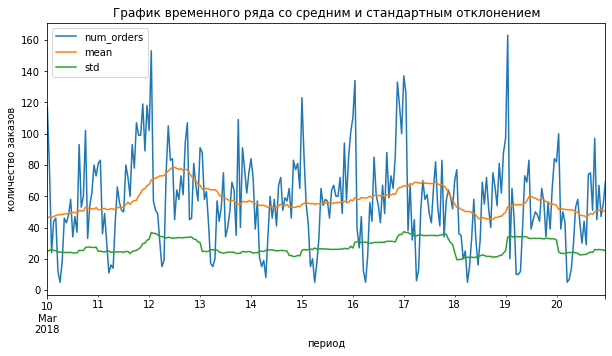

In [17]:
data['2018-03-10':'2018-03-20'].plot(figsize=(10,5), title='График временного ряда со средним и стандартным отклонением')
plt.xlabel('период')
plt.ylabel('количество заказов')
plt.show()

Как видно из графиков, данный временной ряд в целом нестационарен, однако его значительная часть может быт выделена как стационарный стохастический процесс.

Проведем тест Дики-Фулера для проверки стационарности.

In [18]:
test = sm.tsa.adfuller(data['num_orders'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -3.0689242890279327
p-value:  0.028940051402614794
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


Наличие тренда показывает, что ряд не стационарен, однако  тест Дики-Фуллера показывает иначе. 

Произведём дифференцирование временного ряда.

In [19]:
data_diff = data.drop(['mean', 'std'], axis=1)
data_diff.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [20]:
data_diff = data.diff(periods=1).dropna()

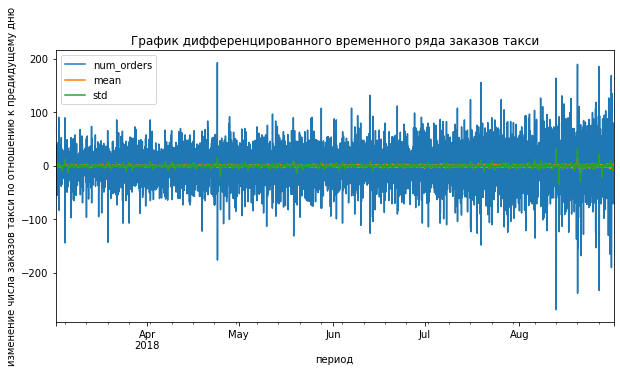

In [21]:
data_diff.plot(figsize=(10,5), title=('График дифференцированного временного ряда заказов такси'))
plt.xlabel('период')
plt.ylabel('изменение числа заказов такси по отношению к предидущему дню')
plt.show()

In [22]:
data_diff.shape

(4392, 3)

In [23]:
# Ряд стал более стационарен, теперь можно прогнозировать.

## 3. Обучение

Создадим признаки для обучения модели, такие как час суток, день недели, месяц.  
Кроме того, нам понадобится предыдущие значения временного ряда и скользящее среднее для предоставления модели данных о тренде.

In [24]:
def make_features(data, max_lag, rolling_mean_size, test_size=0.1):
    
    data = pd.DataFrame(data.copy())
    #data.columns = ["y"]
    
    # определим индекс, после которого начинается тествая часть 
    test_index = int(len(data)*(1-test_size))
    
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    # считаем средние только для тренировочной части
    
    #data['weekday_average'] = map(code_mean(data[:test_index], 'dayofweek', "num_orders").get, data.dayofweek)
    #data['day_average'] = map(code_mean(data[:test_index], 'day', "num_orders").get, data.day)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [25]:
data.shape

(4416, 3)

In [26]:
data = make_features(data, 1, 24)
data = data.drop(['mean', 'std'], axis=1)
data.shape

(4416, 5)

In [27]:
display(data.head(25))

,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN
2018-03-01 02:00:00,71,3,2,85.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,NaN
2018-03-01 05:00:00,6,3,5,43.0,NaN
2018-03-01 06:00:00,12,3,6,6.0,NaN
2018-03-01 07:00:00,15,3,7,12.0,NaN
2018-03-01 08:00:00,34,3,8,15.0,NaN


In [28]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
print('Размеры обучающей и тестовой выборок:', train.shape[0], test.shape[0])

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Размеры обучающей и тестовой выборок: 3950 442


Обучим линейную регрессию. Применим кросс-валидацию для временных рядов TimeSeriesSplit.

Для кросс-валидации напишем функцию метрики rmse

In [29]:
def rmse_funtion(target, prediction):
    '''
    target = target.reset_index(drop=True)
    mse = 0
    for i in range(len(target)):
        mse += (target[i] - prediction[i])**2
       
    rmse = ( 1/len(target) * mse ) **0.5
    '''
    rmse = mean_squared_error(target, prediction)**0.5
    return rmse

score = make_scorer(rmse_funtion, greater_is_better=False)

In [30]:
model_regr_cv = LinearRegression()
tss = TimeSeriesSplit(max_train_size=None, n_splits=5)

scores = cross_val_score(model_regr_cv, features_train, target_train, cv=tss , scoring=score)   # посмотреть доступные метрики: sorted(sklearn.metrics.SCORERS.keys())

print(scores)
mean_score = scores.sum() / len(scores)
print('RMSE обучающей выборки:', mean_score.round(2))

[-26.96819961 -29.42951541 -30.38769452 -32.2295891  -39.95375047]
RMSE обучающей выборки: -31.79


Сравним, как сработает линейная регрессия без кросс-валидации.

In [31]:
model = LinearRegression()
model.fit(features_train, target_train)

predictons_train = model.predict(features_train)
#predictons_test = model.predict(features_test)

print("RMSE обучающей выборки:", mean_squared_error(target_train, predictons_train)**0.5)
#print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictons_test)**0.5)

RMSE обучающей выборки: 30.90708535540955


In [32]:
model_cat = CatBoostRegressor(loss_function = 'RMSE')
model_cat.fit(features_train, target_train)
predictons_train = model_cat.predict(features_train)
#predictons_test = model_cat.predict(features_test)

print("RMSE обучающей выборки:", mean_squared_error(target_train, predictons_train)**0.5)
#print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictons_test)**0.5)

Learning rate set to 0.050868
0:	learn: 37.8259844	total: 141ms	remaining: 2m 20s
1:	learn: 36.8947576	total: 143ms	remaining: 1m 11s
2:	learn: 36.1679234	total: 145ms	remaining: 48.1s
3:	learn: 35.3879228	total: 146ms	remaining: 36.4s
4:	learn: 34.6820118	total: 148ms	remaining: 29.5s
5:	learn: 34.0403800	total: 150ms	remaining: 24.8s
6:	learn: 33.4054021	total: 151ms	remaining: 21.5s
7:	learn: 32.8196563	total: 153ms	remaining: 19s
8:	learn: 32.2245426	total: 155ms	remaining: 17.1s
9:	learn: 31.7235735	total: 158ms	remaining: 15.6s
10:	learn: 31.2046830	total: 160ms	remaining: 14.3s
11:	learn: 30.8316216	total: 161ms	remaining: 13.3s
12:	learn: 30.4656557	total: 163ms	remaining: 12.4s
13:	learn: 30.1050005	total: 165ms	remaining: 11.6s
14:	learn: 29.7653383	total: 166ms	remaining: 10.9s
15:	learn: 29.4406100	total: 169ms	remaining: 10.4s
16:	learn: 29.0874844	total: 171ms	remaining: 9.87s
17:	learn: 28.8156793	total: 172ms	remaining: 9.4s
18:	learn: 28.5231149	total: 174ms	remaining:

In [33]:
model_tree = DecisionTreeRegressor()
parametrs = { 'max_depth': range (6,16, 2),
              'min_samples_leaf': range (1,16,5),
              'min_samples_split': range (2,12,3) }

grid = GridSearchCV(model_tree, parametrs, cv=tss , verbose=1)
grid.fit(features_train, target_train)

grid.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'max_depth': 12, 'min_samples_leaf': 11, 'min_samples_split': 5}

In [34]:
STATE = 1234
model_tree = DecisionTreeRegressor(random_state=STATE, max_depth=12, min_samples_leaf=11, min_samples_split=5)
model_tree.fit(features_train, target_train)
predictons_train = model_tree.predict(features_train)
#predictons_test = model_tree.predict(features_test)

print("RMSE обучающей выборки:", mean_squared_error(target_train, predictons_train)**0.5)
#print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictons_test)**0.5)

RMSE обучающей выборки: 20.711978820322052


In [35]:
model_forest = RandomForestRegressor()
parametrs = { 'n_estimators': range (10, 50, 15),
              'max_depth': range (1,13, 5),
              'min_samples_leaf': range (1,4),
              'min_samples_split': range (2,10,4) }

grid = GridSearchCV(model_forest, parametrs,  cv=tss,verbose=1)

grid.fit(features_train, target_train)
grid.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


{'max_depth': 11,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 25}

In [36]:
model_forest = RandomForestRegressor(random_state=STATE, n_estimators=40, max_depth=11, min_samples_leaf=1, min_samples_split=6)
model_forest.fit(features_train,target_train)
predictons_train = model_forest.predict(features_train)
#predictons_test = model_forest.predict(features_test)

print("RMSE обучающей выборки:", mean_squared_error(target_train, predictons_train)**0.5)
#print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictons_test)**0.5)

RMSE обучающей выборки: 15.927577601628428


In [37]:
model_gbr = GradientBoostingRegressor(random_state=STATE,n_estimators=100, max_depth=7, min_samples_leaf=9, min_samples_split=8)
model_gbr.fit(features_train,target_train)
predictons_train = model_gbr.predict(features_train)
#predictons_test = model_gbr.predict(features_test)

print("RMSE обучающей выборки:", mean_squared_error(target_train, predictons_train)**0.5)
#print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictons_test)**0.5)

RMSE обучающей выборки: 15.704442906832293


Лучшими моделями для обучающей выборки оказались GradientBoostingRegressor и CatBoostRegressor, а также LinearRegression.
Выбираем их для тестовой выборки.

## 4. Тестирование

Протестируем лучшие модели на тестовой выборке.

In [38]:
scores = cross_val_score(model_regr_cv, features_test, target_test, cv=tss , scoring=score)   # посмотреть доступные метрики: sorted(sklearn.metrics.SCORERS.keys())

#print(scores)
mean_score = scores.sum() / len(scores)
print('RMSE тестовой выборки:', mean_score)

RMSE тестовой выборки: -52.36875347206185


In [39]:
predictons_test = model_gbr.predict(features_test)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictons_test)**0.5)

RMSE тестовой выборки:  44.05288679773331


In [40]:
predictons_test = model_cat.predict(features_test)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictons_test)**0.5)

RMSE тестовой выборки:  43.375507137245044


Порог метрики в 48 ед пройден.

## 5. Получение прогноза заказов такси

'''В результате работы моделей мы имеем прогноз разностей временного ряда. Чтобы получить количество заказов, 
нужно к последнему значению временного ряда добавить кумулятивную сумму предсказанных разностей. 
Для этого можно воспользоватся функцией np.cumsum, которая возвращаем массив кумулятивно засуммированных значений исходного массива.
'''

Выведем предсказанные значения заказов для тествой выборки.

In [41]:
# размер массива предсказаний
predictons_test.shape

(442,)

In [42]:
# последнее известное значение - последнее значение  тренировочной выборки
features_train.tail(1)

,dayofweek,hour,lag_1,rolling_mean
datetime,,,,
2018-08-13 13:00:00,0,13,92.0,138.583333


Дата (она же индекс) последнего известного значения - '2018-08-13 13:00:00'

Заменим значение в столбце количества заказов на значение предсказания. Для этого будем добавлятьк последнему извсетвному значению предсказнную разницу временного ряда.

Следует заметить, что такой прогноз показывает неприемлемые значения в долгосрочном периоде. Следовательно, использование проноза для долгосрочно периода не рекомендуется.

Выведем в таблицу и построем график предсказаний тестовой части.

In [48]:
predicton_table = data['2018-08-13 14:00:00':]
predicton_table = predicton_table.drop(['hour','lag_1','rolling_mean'], axis=1)
predicton_table = predicton_table.rename(columns = {'dayofweek':'prediction'})
print(len(predicton_table)==len(predictons_test)) # сверим длины массивов
print(predictons_test[:5])
index_count = 0

for index, row in predicton_table.iterrows():
    row['prediction'] = predictons_test[index_count]
    index_count += 1  
    
display(predicton_table.head())

True
[102.80550059 123.87713951 157.50199238 127.82876844  90.90216485]


,num_orders,prediction
datetime,,
2018-08-13 14:00:00,102,102
2018-08-13 15:00:00,175,123
2018-08-13 16:00:00,144,157
2018-08-13 17:00:00,152,127
2018-08-13 18:00:00,104,90


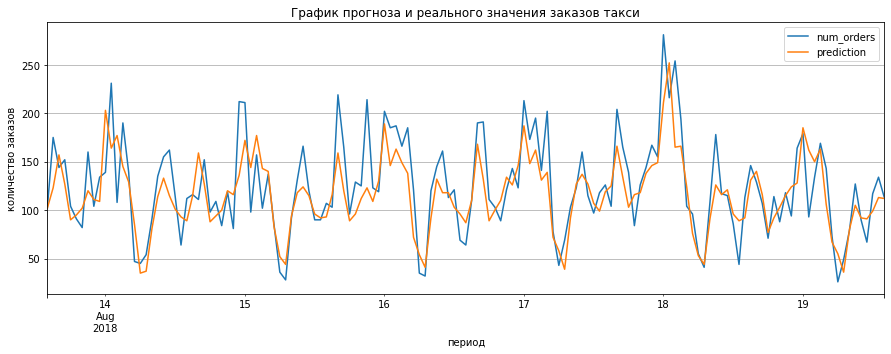

In [49]:
predicton_table[:'2018-08-19 14:00:00'].plot(figsize=(15,5), grid=True, title=('График прогноза и реального значения заказов такси'))
plt.xlabel('период')
plt.ylabel('количество заказов')
plt.show()

Как видно, предсказание модели довольно точно.

## 6. Выводы

В данном исследовании был выполнен анализ датафрема, содержащего информацию о времени и количества заказов такси. Была выполнена кумуляция заказов по часам, и построена модель, прогнозирующая количество заказов на следующий час.   
Результат оформлен в виде таблицы, содержащий информацию о времени и предположительном количестве заказов. 
Также был построен график для сравнения предсказаний модели и реальных заказов.
Для предсказания была использована модель GradientBoostingRegressor.  
Требования качества модели выполнены и проверены на тествой выборке. 